In [1]:
import numpy as np
import pandas as pd

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

import networkx as nx
import gurobipy as gp
from gurobipy import GRB

import time

import matplotlib.pyplot as plt
import seaborn as sns

import csv
import os

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from sklearn.metrics import (
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score,
    adjusted_rand_score
)
from itertools import combinations

In [3]:
import warnings
warnings.filterwarnings('ignore')

## K-Means

In [4]:
def run_kmeans(adjacency_matrix, k, seed=None):
    from sklearn.manifold import MDS
    mds = MDS(n_components=2, dissimilarity='euclidean', random_state=seed)
    coords = mds.fit_transform(adjacency_matrix)
    
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    labels = kmeans.fit_predict(coords)
    
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(labels):
        clusters[label].append(idx)
    return clusters

#### Loading the Dataset

In [5]:
import scipy.io
import numpy as np

In [6]:
def get_correlation_matrix(dataset):
    data = scipy.io.loadmat(rf'hyspectral_data\{dataset}.mat')  # or use the actual file path
    hyperspectral_data = data[dataset]
    num_pixels = hyperspectral_data.shape[0] * hyperspectral_data.shape[1]
    num_bands = hyperspectral_data.shape[2]
    reshaped_data = hyperspectral_data.reshape((num_pixels, num_bands))
    reshaped_data = reshaped_data / np.max(reshaped_data, axis=0)  # Normalize each band
    correlation_matrix = np.corrcoef(reshaped_data, rowvar=False)
    return correlation_matrix

#### Metrics

In [7]:
def signed_modularity(adj_matrix, clusters):
    total_weight = np.sum(np.abs(adj_matrix)) / 2
    modularity = 0
    for cluster in clusters:
        for i, j in combinations(cluster, 2):
            modularity += adj_matrix[i, j]
    return modularity / total_weight

def penalty_metric(adj_matrix, clusters):
    penalty = 0
    for cluster in clusters:
        for i, j in combinations(cluster, 2):
            if adj_matrix[i, j] < 0:  # Penalize intra-cluster negative edges
                penalty += abs(adj_matrix[i, j])
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if i != j and adj_matrix[i, j] > 0:  # Penalize inter-cluster positive edges
                in_same_cluster = any(i in cluster and j in cluster for cluster in clusters)
                if not in_same_cluster:
                    penalty += adj_matrix[i, j]
    return penalty




#### Find Optimal k

In [8]:
def clusters_to_labels(cluster_list, n_nodes):
    labels = np.zeros(n_nodes, dtype=int)
    for i, cluster in enumerate(cluster_list):
        for node in cluster:
            labels[node] = i
    return labels

In [9]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_k(adjacency_matrix, max_k=10):
    distortions = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)

    for k in k_values:
        clusters = run_kmeans(adjacency_matrix, k)
        labels = clusters_to_labels(clusters, len(adjacency_matrix))
        distortions.append(sum(np.min(adjacency_matrix, axis=1)))
        silhouette_scores.append(silhouette_score(adjacency_matrix, labels))

    # # Plot the Elbow Method
    # plt.figure(figsize=(10, 5))
    # plt.plot(k_values, distortions, 'bx-', label='Distortion')
    # plt.xlabel('Number of clusters (k)')
    # plt.ylabel('Distortion')
    # plt.title('Elbow Method for Optimal k')
    # plt.legend()
    # plt.show()

    # Return the k with the highest silhouette score
    optimal_k = k_values[np.argmax(silhouette_scores)]
    return optimal_k

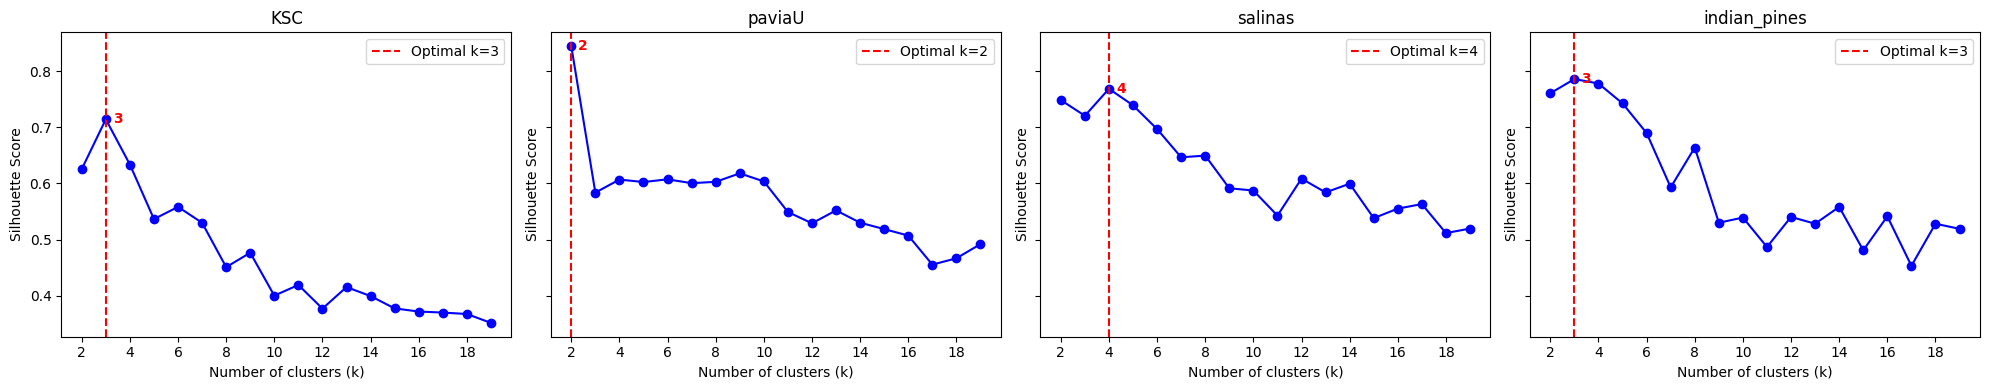

In [10]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

available_datasets = ['KSC', 'paviaU', 'salinas', 'indian_pines']
all_silhouette_scores = []
all_k_values = []
all_optimal_k = []

for dataset in available_datasets:
    correlation_matrix = get_correlation_matrix(dataset)
    # max_k = correlation_matrix.shape[0]
    max_k = 20
    k_values = range(2, max_k)
    silhouette_scores = []
    for k in k_values:
        clusters = run_kmeans(correlation_matrix, k)
        labels = clusters_to_labels(clusters, len(correlation_matrix))
        silhouette_scores.append(silhouette_score(correlation_matrix, labels))
    all_silhouette_scores.append(silhouette_scores)
    all_k_values.append(list(k_values))
    all_optimal_k.append(k_values[np.argmax(silhouette_scores)])

# Plot all silhouette scores as subplots
fig, axes = plt.subplots(1, len(available_datasets), figsize=(5 * len(available_datasets), 4), sharey=True)
if len(available_datasets) == 1:
    axes = [axes]
for idx, dataset in enumerate(available_datasets):
    axes[idx].plot(all_k_values[idx], all_silhouette_scores[idx], 'o-', color='b')
    axes[idx].set_title(dataset)
    axes[idx].set_xlabel('Number of clusters (k)')
    axes[idx].set_ylabel('Silhouette Score')
    axes[idx].axvline(all_optimal_k[idx], color='r', linestyle='--', label=f'Optimal k={all_optimal_k[idx]}')
    # Annotate the red line with its value
    axes[idx].annotate(f'{all_optimal_k[idx]}', 
                       xy=(all_optimal_k[idx], max(all_silhouette_scores[idx])), 
                       xytext=(5, 0), textcoords='offset points',
                       color='red', fontsize=10, fontweight='bold',
                       va='center', ha='left', rotation=0)
    axes[idx].legend()
    # Set x-ticks to even numbers only
    even_ticks = [k for k in all_k_values[idx] if k % 2 == 0]
    axes[idx].set_xticks(even_ticks)
plt.tight_layout()
fig.savefig(r"plots/finding-optimal-k-EO.png", dpi=300, bbox_inches='tight')
plt.show()
